# Information-theoretic analysis of EEG microstates in Python

In [1]:
from IPython.core.display import display, HTML, Image

In [2]:
from eeg_microstates import *

## Background and links

### Github link of this project

In [4]:
HTML('<a href="https://github.com/Frederic-vW/eeg_microstates/tree/master/">Github link of this project</a>')

### Current literature about EEG microstates

In [5]:
url = 'https://www.ncbi.nlm.nih.gov/pubmed/?term=eeg+microstates'
iframe = '<iframe src=' + url + ' width=1200 height=500></iframe>'
HTML(iframe)

## Microstate clustering

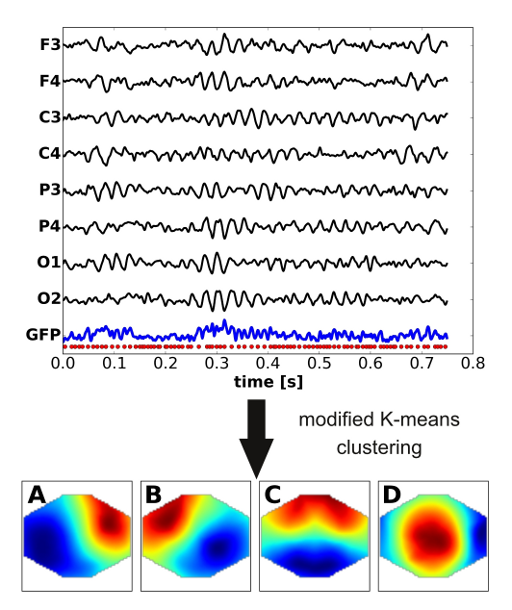

In [6]:
Image(filename='Figure_1.png')

## (1) EEG data input

The package contains a basic [EDF](http://www.edfplus.info/specs/edf.html) file reader.

In [7]:
filename = "test.edf"
chs, fs, data_raw = read_edf(filename)
print("\n\tFile: {}".format(filename))
print("\t\tSampling rate: {:.2f} Hz".format(fs))
print("\t\tData shape: {:d} samples x {:d} channels".format(data_raw.shape[0], data_raw.shape[1]))
print("\t\tChannels:")
for ch in chs: print "\t\t{:s}".format(ch)


	File: test.edf
		Sampling rate: 250.00 Hz
		Data shape: 48000 samples x 30 channels
		Channels:
		Fp1
		Fp2
		F3
		F4
		C3
		C4
		P3
		P4
		O1
		O2
		F7
		F8
		T7
		T8
		P7
		P8
		Fz
		Cz
		Pz
		AFz
		AF3
		AF4
		FC3
		FC4
		FT9
		FT10
		TP9
		TP10
		CP5
		CP6


## (2) Apply band-pass filter 5-20 Hz (6-th order Butterworth)

In [8]:
data = bp_filter(data_raw, (8, 15), fs)

## (3) Visualize data (PCA-1)

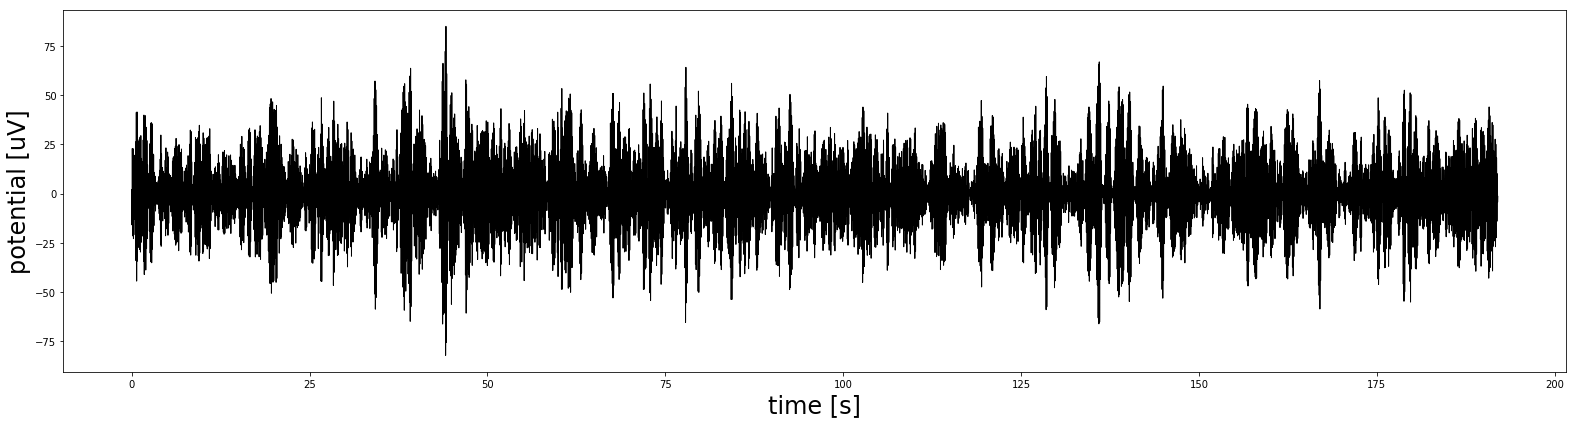

In [9]:
pca = PCA(copy=True, n_components=1, whiten=False)
pca1 = pca.fit_transform(data)[:,0]
del pca
plot_data(pca1, fs)

## (4) Modified K-means clustering

		K-means 1: 13 iterations


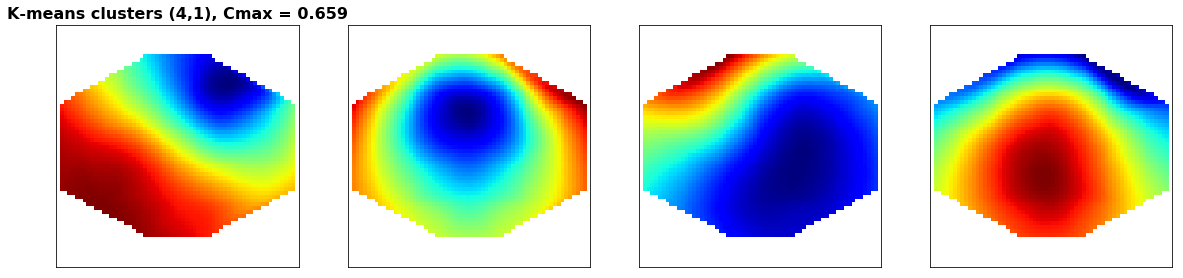


	Assign map labels (e.g. 0, 2, 1, 3): 2,1,3,0


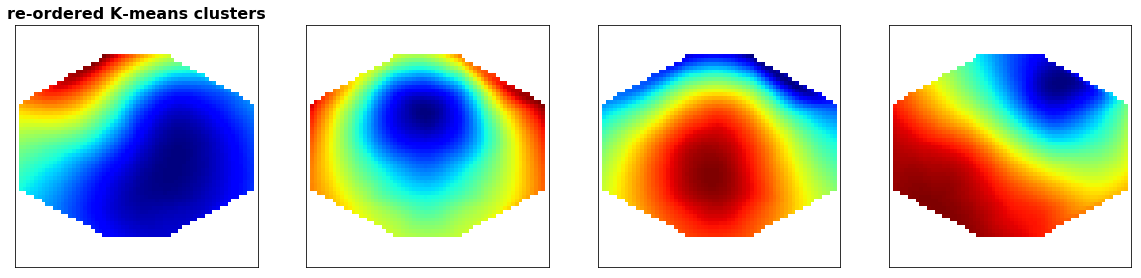

		K-means clustering of: n = 3803 EEG maps
		Microstates: 4 clusters x 30 channels
		Global explained variance GEV = 0.77
		Cross-validation criterion 16150.51


In [10]:
n_clusters = 4
n_runs = 1
maxerr = 0.05
clusters, x, gfp_peaks, gev, cv = kmeans(data, n_clusters, n_runs, maxerr, doplot=True)
print("\t\tK-means clustering of: n = {:d} EEG maps".format(len(gfp_peaks)) )
print("\t\tMicrostates: {:d} clusters x {:d} channels".format(clusters.shape[0],clusters.shape[1]) )
print("\t\tGlobal explained variance GEV = {:.2f}".format(gev.sum()))
print("\t\tCross-validation criterion {:.2f}".format(cv))

## (5) Basic microstate statistics

In [11]:
p_hat = p_empirical(x, n_clusters)
T_hat = T_empirical(x, n_clusters)
print("\n\t\tEmpirical symbol distribution (RTT):\n")
for i in range(n_clusters): print("\t\tp_{:d} = {:.3f}".format(i, p_hat[i]))
print("\n\t\tEmpirical transition matrix:\n")
print_matrix(T_hat)
# RTT (ratio time covered A-D)
#rtt = [1.*x.tolist().count(i)/len(x) for i in range(n_clusters)]
# given in basic statistics
# PPS (peaks per second)
pps = len(gfp_peaks) / (len(x)/fs)
print("\n\t\tGFP peaks per sec.: {:.2f}".format(pps))
# MMD (mean microstate duration A-D)
# given in Markov tests
# GEV (global explained variance A-D)
print("\n\t\tGlobal explained variance (GEV) per map:")
print "\t\t" + str(gev)
print("\n\t\ttotal GEV: {:.2f}".format(gev.sum()))


		Empirical symbol distribution (RTT):

		p_0 = 0.292
		p_1 = 0.239
		p_2 = 0.224
		p_3 = 0.245

		Empirical transition matrix:

		|0.796 0.101 0.058 0.044|
		|0.057 0.765 0.088 0.090|
		|0.094 0.057 0.763 0.086|
		|0.101 0.057 0.061 0.781|

		GFP peaks per sec.: 19.81

		Global explained variance (GEV) per map:
		[ 0.13486205  0.12156602  0.36259777  0.15300826]

		total GEV: 0.77


## (6) Entropy of the microstate sequence

In [12]:
h_hat = H_1(x,n_clusters)
h_max = max_entropy(n_clusters)
print("\n\t\tEmpirical entropy H = {:.2f} (max. entropy: {:.2f})\n".format(h_hat,h_max) )


		Empirical entropy H = 1.38 (max. entropy: 1.39)



## (7) Markov tests

In [13]:
alpha = 0.01
p0 = testMarkov0(x, n_clusters, alpha)
p1 = testMarkov1(x, n_clusters, alpha)
p2 = testMarkov2(x, n_clusters, alpha)
p_geo_vals = geoTest(x, n_clusters, 1000./fs, alpha)

		ZERO-ORDER MARKOVITY:
		p: 0.00e+00 | t: 59104.732 | df: 9.0

		FIRST-ORDER MARKOVITY:
		p: 1.21e-184 | t: 991.014 | df: 36.0

		SECOND-ORDER MARKOVITY:
		p: 8.50e-167 | t: 1204.530 | df: 144.0

		GEOMETRIC DISTRIBUTION of lifetimes:

		Testing the distribution of symbol # 0
		p: 2.39e-91 | t: 540.845 | df: 36.0
		G-test (log-likelihood) p: 2.54e-46, g: 315.238, df: 36.0
		G-test (Pearson Chi2) p: 8.28e-37, g: 265.652, df: 36.0
		mean dwell time: 15.65 [ms]
		max. dwell time: 148.00 [ms]


		Testing the distribution of symbol # 1
		p: 2.91e-45 | t: 331.253 | df: 45.0
		G-test (log-likelihood) p: 5.31e-20, g: 191.601, df: 45.0
		G-test (Pearson Chi2) p: 9.92e-16, g: 165.803, df: 45.0
		mean dwell time: 13.04 [ms]
		max. dwell time: 184.00 [ms]


		Testing the distribution of symbol # 2
		p: 4.74e-48 | t: 350.641 | df: 47.0
		G-test (log-likelihood) p: 1.32e-21, g: 204.899, df: 47.0
		G-test (Pearson Chi2) p: 2.35e-15, g: 167.049, df: 47.0
		mean dwell time: 12.87 [ms]
		max. dwell tim

## (8) Stationarity test

In [14]:
try:
    L = int(raw_input("\t\tenter block size: "))
except:
    L = 5000
p3 = conditionalHomogeneityTest(x, n_clusters, L, alpha)

		enter block size: 3000

		CONDITIONAL HOMOGENEITY (three-way table):
		Split data in r = 16 blocks of length 3000.
		p: 1.11e-64 | t: 714.042 | df: 180.0


## (9) Symmetry test

In [15]:
p4 = symmetryTest(x, n_clusters, alpha)


		SYMMETRY:
		p: 5.26e-147 | t: 695.672 | df: 6.0


## (10) Markov surrogate example

In [16]:
x_mc = surrogate_mc(p_hat, T_hat, n_clusters, len(x))
p_surr = p_empirical(x_mc, n_clusters)
T_surr = T_empirical(x_mc, n_clusters)
print("\n\t\tSurrogate symbol distribution:\n")
for i in range(n_clusters): print("\t\tp_{:d} = {:.3f}".format(i, p_surr[i]))
print( "\n\t\tSurrogate transition matrix:\n" )
print_matrix(T_surr)


		Surrogate symbol distribution:

		p_0 = 0.290
		p_1 = 0.244
		p_2 = 0.223
		p_3 = 0.243

		Surrogate transition matrix:

		|0.794 0.103 0.058 0.046|
		|0.057 0.767 0.084 0.092|
		|0.092 0.059 0.766 0.083|
		|0.104 0.058 0.061 0.778|


## (11) Markov tests for surrogate (model check)

In [17]:
p0_ = testMarkov0(x_mc, n_clusters, alpha)
p1_ = testMarkov1(x_mc, n_clusters, alpha)
p2_ = testMarkov2(x_mc, n_clusters, alpha)
p_geo_vals_ = geoTest(x_mc, n_clusters, 1000./fs, alpha)

		ZERO-ORDER MARKOVITY:
		p: 0.00e+00 | t: 58969.370 | df: 9.0

		FIRST-ORDER MARKOVITY:
		p: 2.01e-01 | t: 42.858 | df: 36.0

		SECOND-ORDER MARKOVITY:
		p: 2.28e-01 | t: 156.335 | df: 144.0

		GEOMETRIC DISTRIBUTION of lifetimes:

		Testing the distribution of symbol # 0
		p: 9.46e-01 | t: 23.499 | df: 36.0
		G-test (log-likelihood) p: 1.00e+00, g: 12.632, df: 36.0
		G-test (Pearson Chi2) p: 1.00e+00, g: 10.752, df: 36.0
		mean dwell time: 15.39 [ms]
		max. dwell time: 148.00 [ms]


		Testing the distribution of symbol # 1
		p: 6.65e-02 | t: 45.946 | df: 33.0
		G-test (log-likelihood) p: 9.36e-01, g: 21.583, df: 33.0
		G-test (Pearson Chi2) p: 9.58e-01, g: 20.405, df: 33.0
		mean dwell time: 13.15 [ms]
		max. dwell time: 136.00 [ms]


		Testing the distribution of symbol # 2
		p: 2.61e-01 | t: 31.260 | df: 27.0
		G-test (log-likelihood) p: 9.75e-01, g: 14.547, df: 27.0
		G-test (Pearson Chi2) p: 9.84e-01, g: 13.655, df: 27.0
		mean dwell time: 13.10 [ms]
		max. dwell time: 112.00 [ms

## (12) Stationarity test for surrogate Markov chain (model check)

In [18]:
try:
    L = int(raw_input("\t\tenter block size: "))
except:
    L = 5000
p3_ = conditionalHomogeneityTest(x_mc, n_clusters, L, alpha)

		enter block size: 5000

		CONDITIONAL HOMOGENEITY (three-way table):
		Split data in r = 9 blocks of length 5000.
		p: 5.24e-01 | t: 94.494 | df: 96.0


## (13) Symmetry test for surrogate Markov chain (model check)

In [19]:
p4_ = symmetryTest(x_mc, n_clusters, alpha)


		SYMMETRY:
		p: 5.90e-144 | t: 681.545 | df: 6.0


## (14) Time-lagged mutual information (AIF) empirical vs. Markov model

		mutual information lag: 90


		Computing n = 10 Markov surrogates...

		surrogate MC # 0
		mutual information lag: 90

		surrogate MC # 1
		mutual information lag: 90

		surrogate MC # 2
		mutual information lag: 90

		surrogate MC # 3
		mutual information lag: 90

		surrogate MC # 4
		mutual information lag: 90

		surrogate MC # 5
		mutual information lag: 90

		surrogate MC # 6
		mutual information lag: 90

		surrogate MC # 7
		mutual information lag: 90

		surrogate MC # 8
		mutual information lag: 90

		surrogate MC # 9
		mutual information lag: 90



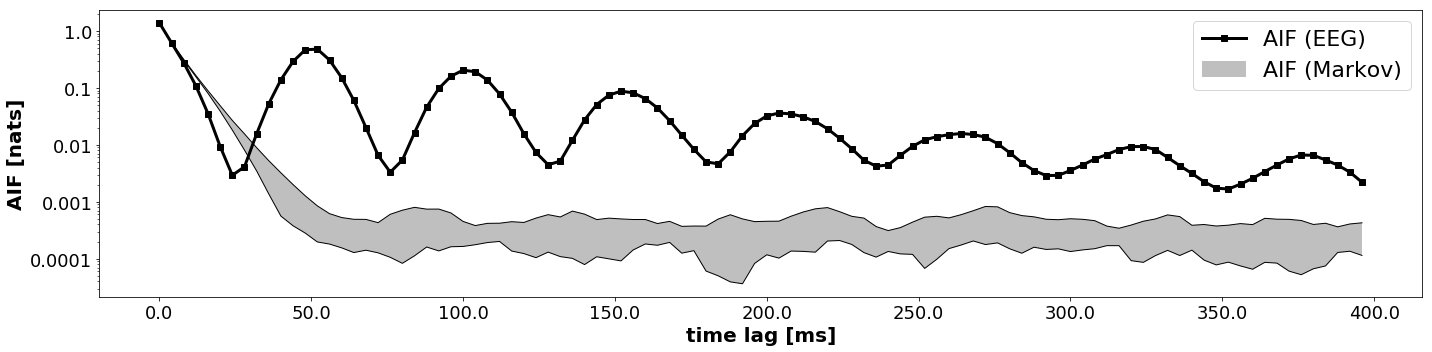

In [20]:
l_max = 100
n_mc = 10
aif = mutinf(x, n_clusters, l_max)
print("\n\t\tComputing n = {:d} Markov surrogates...\n".format(n_mc))
aif_array = mutinf_CI(p_hat, T_hat, len(x), alpha, n_mc, l_max)
pct = np.percentile(aif_array,[100.*alpha/2.,100.*(1-alpha/2.)],axis=0)
plt.ioff()
fig = plt.figure(1, figsize=(20,5))
fig.patch.set_facecolor('white')
t = np.arange(l_max)*1000./fs
plt.semilogy(t, aif, '-sk', linewidth=3, label='AIF (EEG)')
plt.semilogy(t, pct[0,:], '-k', linewidth=1)
plt.semilogy(t, pct[1,:], '-k', linewidth=1)
plt.fill_between(t, pct[0,:], pct[1,:], facecolor='gray', alpha=0.5, label='AIF (Markov)')
plt.xlabel("time lag [ms]", fontsize=20, fontweight="bold")
plt.ylabel("AIF [nats]", fontsize=20, fontweight="bold")
plt.legend(fontsize=22)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticks(), fontsize=18, fontweight='normal')
ax.set_yticklabels(ax.get_yticks(), fontsize=18, fontweight='normal')
plt.tight_layout()
plt.show()

### Confidence interval from Markov surrogates